In [1]:
import pandas as pd
import numpy as np
import json

airlocation_ids = [964, 967, 968, 969, 972, 974, 976, 977]
dfs = [(id, pd.DataFrame.from_csv('predict_aqi/results_data/{}.csv'.format(id))) for id in airlocation_ids]

HYPERPARAMETERS_AND_ERROR = ['hidden_layer_sizes', 'alpha', 'indices_behind_to_use_range', 'number_of_nearby_locations_to_use', 'total_error']

In [2]:
def string_to_dict(string_of_dict):
    return json.loads(string_of_dict.replace("'", '"'))

top_10s = []
top_50s = []
top_50s_start = []
top_50s_end = []
top_xs_dfs = [
    ('Top 10', top_10s),
    ('Top 50', top_50s),
    ('Top 50 start', top_50s_start),
    ('Top 50 end', top_50s_end)
]

for id, df in dfs:
    df['total_error'] = df['error_results'].map(lambda a: sum(string_to_dict(a).values()))
    df['9_ahead_error'] = df['error_results'].map(lambda a: string_to_dict(a)['2_ahead'])
    df['41_ahead_error'] = df['error_results'].map(lambda a: string_to_dict(a)['46_ahead'])
    df['hidden_layer_sizes'] = df['hidden_layer_sizes'].map(lambda a: str(a))
    top_10s.append((id, df.sort_values('total_error')[:10]))
    top_50s_start.append((id, df.sort_values('9_ahead_error')[:50]))
    top_50s_end.append((id, df.sort_values('41_ahead_error')[:50]))
    top_50s.append((id, df.sort_values('total_error')[:50]))
print(df.columns)

Index(['indices_behind_to_use_range', 'number_of_nearby_locations_to_use',
       'hidden_layer_sizes', 'alpha', 'airlocation_id',
       'nearby_airlocation_ids', 'prediction_type', 'error_results',
       'total_error', '9_ahead_error', '41_ahead_error'],
      dtype='object')


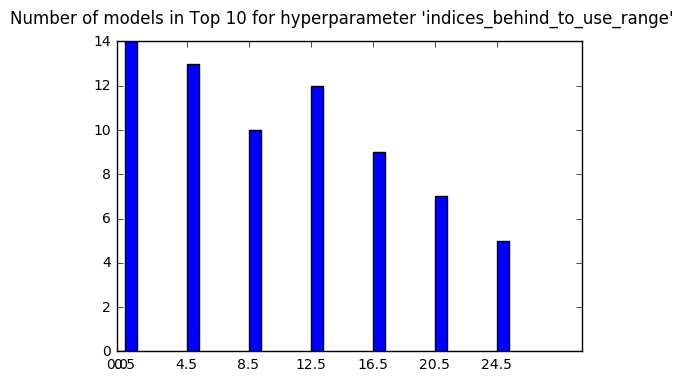

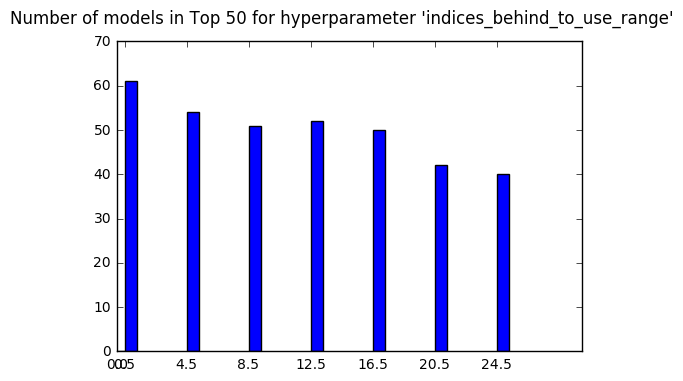

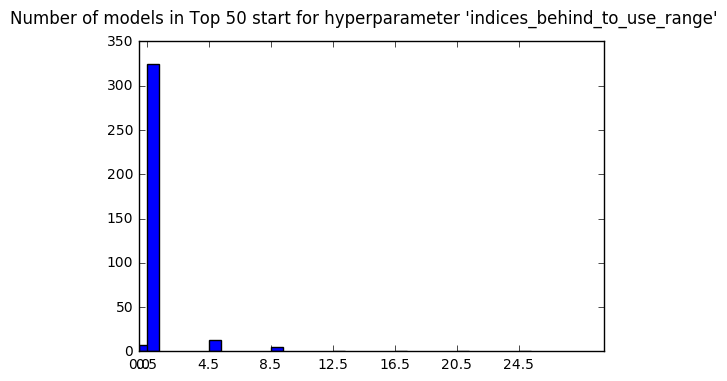

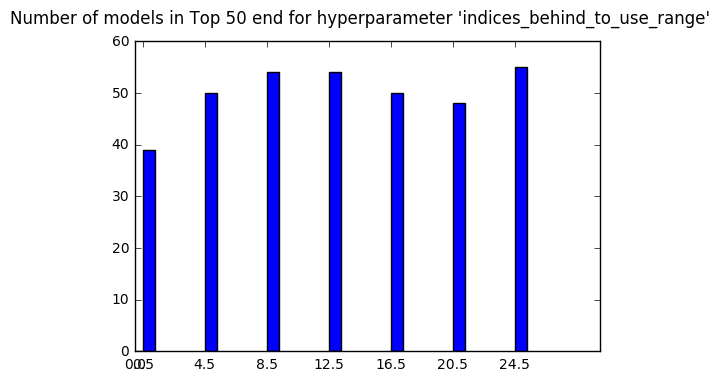

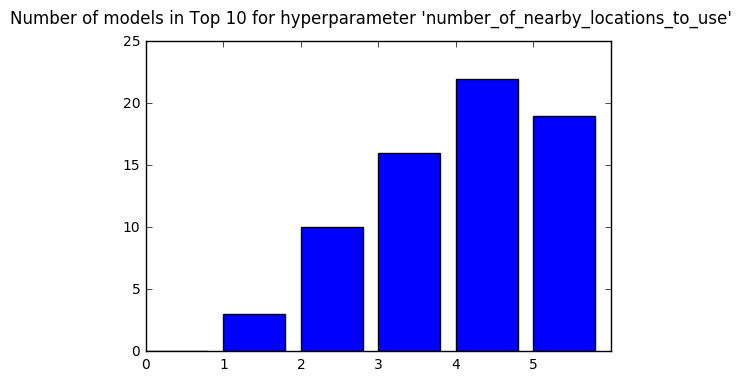

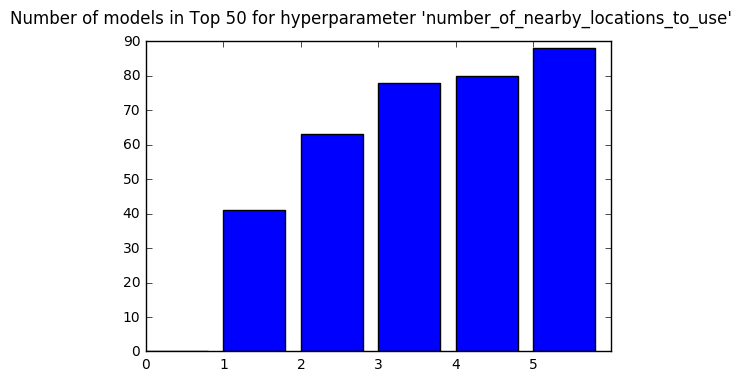

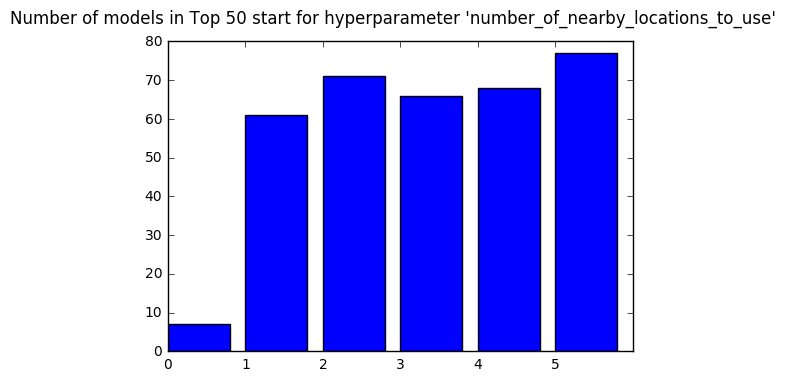

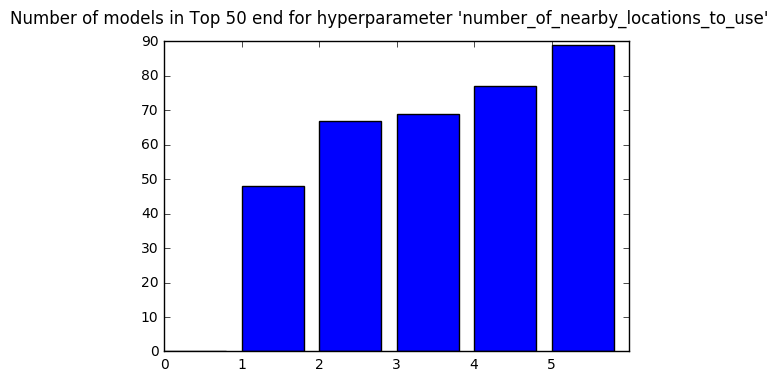

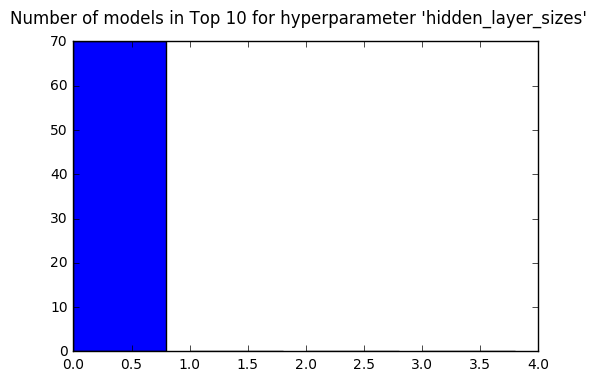

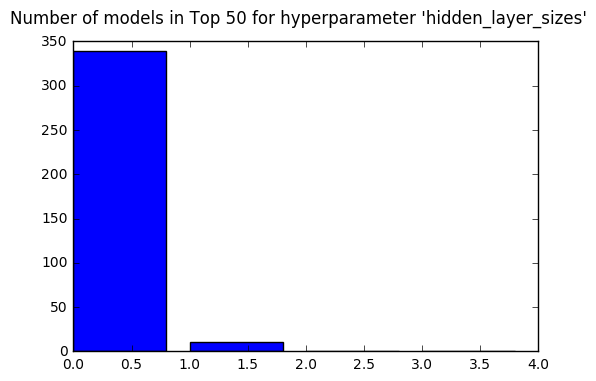

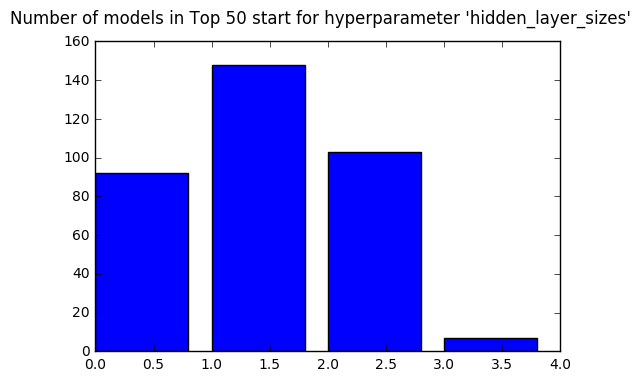

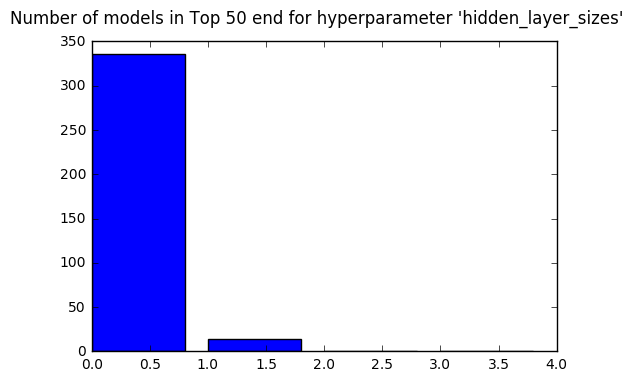

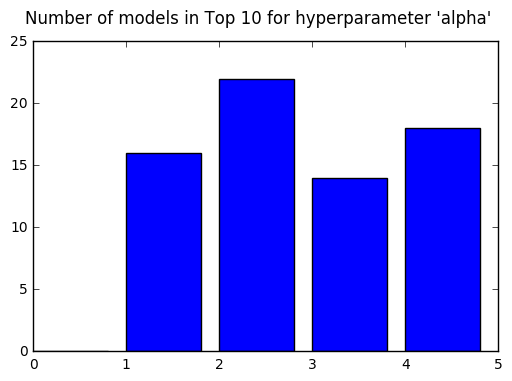

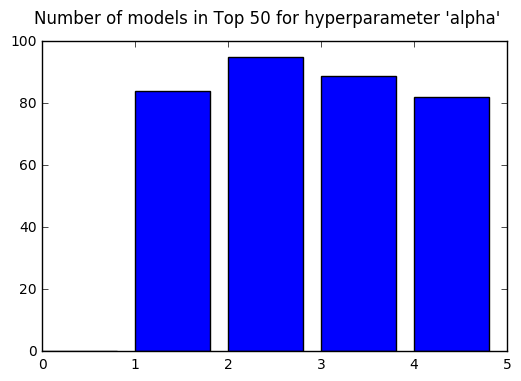

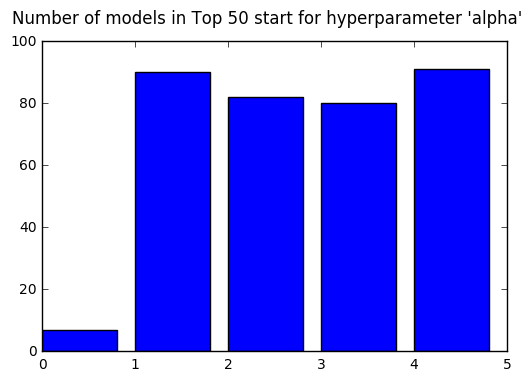

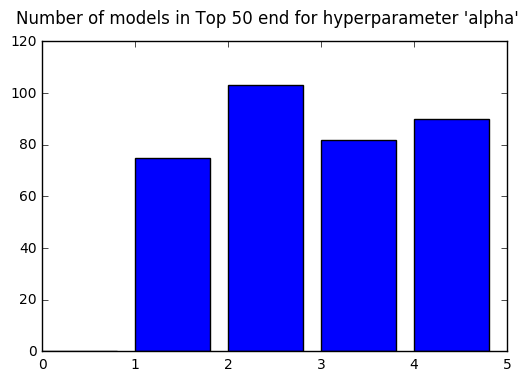

{'nan': 3, '(100, 10)': 0, '(24,)': 2, '(100,)': 1}


In [211]:
import matplotlib.pyplot as plt


hidden_layer_sizes = sorted(list(set(df['hidden_layer_sizes'])))
mapped_hidden_layer_sizes = {value: i for i, value in enumerate(hidden_layer_sizes)}

alphas = sorted(list(set(df['alpha'])))
mapped_alphas = {value: i for i, value in enumerate(alphas)}

x_axes = [
    (
        'indices_behind_to_use_range', 
        lambda a: int(a.replace('range(0, ', '').replace(', 2)', '')) / 2 if type(a) is str else 0,
        [0, 0.5, 4.5, 8.5, 12.5, 16.5, 20.5, 24.5],
        [0, 0.5, 4.5, 8.5, 12.5, 16.5, 20.5, 24.5],
    ),
    (
        'number_of_nearby_locations_to_use',
        lambda a: int(a) if not np.isnan(a) else 0,
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
    ),
    (
        'hidden_layer_sizes',
        # let '.' mean a comma
        lambda a: mapped_hidden_layer_sizes[a] if type(a) is str else 0,
        [0, 1, 2, 3],
        None,
    ),
    (
        'alpha',
        lambda a: mapped_alphas[a] if not np.isnan(a) else 0,
        [0, 1, 2, 3, 4],
        None,
        
    )
]

for column_name, x_value_function, possible_x_values, x_ticks in x_axes:
    for name, top_xs_df in top_xs_dfs:
        x_value_map = {i: 0 for i in possible_x_values}
        for index, (airlocation_id, top_x_df) in enumerate(top_xs_df):
            x_values = top_x_df[column_name].map(x_value_function)
            for x_value in x_values:
                x_value_map[x_value] += 1
            
        plt.bar(
            possible_x_values,
            [x_value_map[x] for x in possible_x_values],
        )
        if x_ticks:
            plt.xticks(x_ticks)
        
        plt.suptitle("Number of models in {} for hyperparameter '{}'".format(name, column_name), fontsize=12)
        plt.show()
print(mapped_hidden_layer_sizes)

In [212]:
for id, top_10 in top_10s:
    print(top_10[HYPERPARAMETERS_AND_ERROR])

     hidden_layer_sizes    alpha indices_behind_to_use_range  \
702           (100, 10)  0.00050             range(0, 17, 2)   
1118          (100, 10)  0.00010             range(0, 33, 2)   
462           (100, 10)  0.00050              range(0, 9, 2)   
456           (100, 10)  0.00100              range(0, 9, 2)   
878           (100, 10)  0.00010             range(0, 25, 2)   
228           (100, 10)  0.00010              range(0, 1, 2)   
344           (100, 10)  0.00005              range(0, 9, 2)   
297           (100, 10)  0.00005              range(0, 9, 2)   
158           (100, 10)  0.00010              range(0, 1, 2)   
1428          (100, 10)  0.00010             range(0, 41, 2)   

      number_of_nearby_locations_to_use  
702                                 5.0  
1118                                4.0  
462                                 5.0  
456                                 5.0  
878                                 4.0  
228                                 5.0  
3

In [223]:
indices_ahead_to_predict_range = range(2, 49, 11)

plt.figure(figsize=(15, 10))
plt.axis([0.0, 25.0, 0.0, 35.0])
baseline_error_dict = dfs[0][1].iloc[1680]['error_results']
baseline_error_dict = json.loads(baseline_error_dict.replace("'", '"'))

plt.plot(
    [h // 2 for h in indices_ahead_to_predict_range],
    [baseline_error_dict['{}_ahead'.format(i)] for i in indices_ahead_to_predict_range], 
    label="baseline model prediction error",
    color="Red"
)
for row in top_10s[0][1]:
    error_dict = row['error_results']
    error_dict = json.loads(error_dict.replace("'", '"'))
    plt.plot(
        [h // 2 for h in indices_ahead_to_predict_range],
        [error_dict['{}_ahead'.format(i)] for i in indices_ahead_to_predict_range], 
        color="Blue"
    )